<a href="https://colab.research.google.com/github/fpinell/mlsa/blob/main/notebooks/Lecture_6_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Software Analysis (MLSA)

## University of Florence -- IMT School for Advanced Studies Lucca

### Fabio Pinelli
<a href="mailto:fabio.pinelli@imtlucca.it">fabio.pinelli@imtlucca.it</a><br/>
IMT School for Advanced Studies Lucca<br/>
2024/2025<br/>
November, 11 2024

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter10()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *
from plots.chapter10 import *

Finished!


In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms.v2 import Compose, Normalize, Pad

from data_generation.square_sequences import generate_sequences
from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 9
from seq2seq import PositionalEncoding, subsequent_mask, EncoderDecoderSelfAttn

# Transform and Roll Out!

A quick summary about last time:

- Self-attention ---> used where?
- Target mask --> to avoid what?
- Positional Enconding --> why?

At the end of the lesson we reached this code

In [3]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)

    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask

    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq,
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs

    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs

    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)

        return outputs

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)  ##<----

    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out

class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features) #<----

    def init_keys(self, states):
        self.layer.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

In [5]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )

    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )

    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model,
                                                   input_dim=input_dim,
                                                   proj_values=proj_values)
                                         for _ in range(n_heads)])

    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)

    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)

    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        out = self.linear_out(concatenated) # N, 1, D
        return out

    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None

    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys

    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores

    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()

        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

This architecture that includes:
- Encoder self attention with Positional Encoding
- Decoder self-attention with Positional Enconding
- Multihead self and cross attention
- and the rest of the details we discussed last time

Is very close to the famouse transformer architecture (ref: attention is all you need paper.)

We need some little adjustment and some tricks to have the same model.  

1. *Narrow attention* vs *wide attention*
2. Layer normalization
3. some other operations and more "*layers*"

## **Narrow attention** vs **wide attention**

- **[Wide attention]**: Our previous architecture uses *full* attention heads to build a multi-headed attention mechanism. This can be computationally expensive when the number of  dimensions of the model gets large.  

- **[Narrow attention]**: each attention head will get a chunck of the transformed data points (or their projections) to work with.


### Chunking

This time we have 4 features for each data point.

They pass through an affine transformation to generate the values ($V_0$) for the first data point ($x_0$)

Then, the resulting 4 dimensions are chunked and passed to the different heads.

Since each head is working with a subset of the projected dimensions, these may end up representing different aspectects if the underlying data.


![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attn_narrow_transf.png?raw=1)

One could/would chunk the input data, but with this approach (right) some information and relationships among the feature can be lost.


![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/multihead_chunking.png?raw=1)



![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attn_narrow_first_head.png?raw=1)

1. Both data points ($x_0$ and $x_1$) go through the affine transformations to generate the corresponding "values" ($v_0$ and $v_1$) and keys ($k_0$ and $k_1$), calling them **projections**.

2. Another affine transformation to generate queries ($q_0$ and $q_1$)

3. Each projection has the same number of dimensions as the inputs

4. The attention head uses only a chunk of the projections to compute its context vector.

5. We split the projections in two chunks of two dimensions each

6. The first attention head uses only the blue chunk, the second attention head will use the second chunk in green. They both comput a half of the context vector

7. Finally the context-vector goes through a FFN to generate the hidden states.


### Multiheaded Attention

In [7]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))

    def score_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query,
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores

    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_function(query) # N, n_heads, L, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()

        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context

    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out

    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)
        # N, L, d_model
        out = self.output_function(context)
        return out

- ```make_chunks()``` it takes a tensor of shape (N,L,D) and splits its last dimension in two, resulting in a (N,L, n_heads, $d_k$) shape, where $d_k$ is the size of the chunk ($d_k = \frac{D}{n_{heads}}$)

- The init_keys makes the projection for k and v and chunk them.

- ```score_function()``` Chunks the projected queries and computes the scaled do product

- ```att()``` corresponds to the ```forward()``` computing attention scores and the chunks of the context-vectors (plus a dropout for regolarization).

- ```output_function()``` the context-vectors go through the FFN since the concatenation is going to happen in the forward.

- ``forward()``` calls the ```attn()``` and reorganizes the dimensions of the result to concatenate the chunks of the context vector.

In [8]:
dummy_points = torch.randn(16, 2, 4) # N, L, F
mha = MultiHeadedAttention(n_heads=2, d_model=4, dropout=0.0)
mha.init_keys(dummy_points)
out = mha(dummy_points) # N, L, D
out.shape

torch.Size([16, 2, 4])

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attn_narrow_2heads.png?raw=1)

Main message: the heads use a chunk of the **projections** and not the inputs, directly.

## Stacking Encoders and Decoders

We can make our architecture **deeper** by stacking two encoders on top of one another and we can do the same with two decoders.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/stacked_encdec.png?raw=1)

The output of one encoder feeds the next and *last encoder* outputs the **states**.

These states will feed the cross-attention of ALL stacked decoders.

The output of one decoder feeds the next, and the last decoder output the final predictions (as usual).

Each encoder is now called **layer** and a stack of layers composes a new, deeper encoder. The *same* for the **decoder**.

Each basic "*operation*", i.e., multi headed self attention, cross attention and feed forward inside a layer is now called **sub-layer**.

We can stack more than 2 layers... for instance 6...



![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/stacked_layers.png?raw=1)

## Wrapping "Sub-Layers"

Complex architectures can have "familiar" issues, like the vanishing gradients problem.

Typically, to avoid these situations, we use:
- Dropout for regularization
- Residual connections: batch/layer normalization (standardize the features, give a bound to the values)
  + norm-last employs a normalization layer before the output
  + norm-first employs a normalization layer on the input.


## Key Idea of Residual Connections
A residual connection adds the input of a layer to its output before passing it to the next layer. This allows the network to learn the difference, or residual, between the input and the desired output rather than trying to learn the full mapping in one step.

In mathematical terms, for a given layer
$𝐹(𝑥)$ that maps input $𝑥$ to some output, a residual connection modifies the layer to compute:

$output = 𝐹(𝑥)+𝑥$
where:

$F(x)$ is the transformation applied by the layer (e.g., a series of convolutions, self-attention, or fully connected layers).
$x$ is the original input, which is added to
$F(x)$.

### Why Residual Connections Are Useful
#### Improved Gradient Flow:

In deep networks, gradients can become very small as they are backpropagated through each layer, which can lead to vanishing gradients and prevent effective learning.
Residual connections provide a direct pathway for gradients to flow from later layers back to earlier ones, making it easier for gradients to propagate through the entire network, even when it's very deep.
#### Helps Preserve Information:

Adding the input $x$ directly to the output
$F(x)$ helps retain information from earlier layers, ensuring that the original input information is preserved across multiple layers. This is crucial in very deep architectures where transformations can gradually distort or lose information.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/sublayer.png?raw=1)

$$
\Large
\begin{aligned}
&\text{outputs}_{\text{norm-last}}=&\text{norm(inputs + dropout(sublayer(inputs))}
\\
&\text{outputs}_{\text{norm-first}}=&\text{inputs + dropout(sublayer(norm(inputs)))}
\end{aligned}
$$

## Transformer Encoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/enc_both.png?raw=1)

$$
\large
\begin{aligned}
&\text{outputs}_{\text{norm-last}}=&\text{norm}(\underbrace{\text{norm(inputs + att(inputs))}}_{\text{Output of SubLayer}_0} + \text{ffn}(\underbrace{\text{norm(inputs + att(inputs))}}_{\text{Output of SubLayer}_0}))
\\
\\
&\text{outputs}_{\text{norm-first}}=&\underbrace{\text{inputs + att(norm(inputs))}}_{\text{Output of SubLayer}_0}+\text{ffn(norm(}\underbrace{\text{inputs + att(norm(inputs))}}_{\text{Output of SubLayer}_0}))
\end{aligned}
$$

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, query, mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Multi-headed Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, mask)
        # Add
        att = query + self.drop1(states)

        # Sublayer #1
        # Norm
        norm_att = self.norm2(att)
        # Feed Forward
        out = self.ffn(norm_att)
        # Add
        out = att + self.drop2(out)
        return out

In [10]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])

    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

In [11]:
enclayer = nn.TransformerEncoderLayer(d_model=6, nhead=3, dim_feedforward=20)
enctransf = nn.TransformerEncoder(enclayer, num_layers=1, norm=nn.LayerNorm)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


The encoder layer is implemented in pytorch as ```nn.TransformEncoderLayer```

PyTorch transformer layers use sequence-first shape for their inputs (L,N,F) and there is no batch-first option.

There is also ```nn.TransformerEncoder``` and it expects similar arguments: encoder layer and the number of layers.

It doesn't perform Positional Enconding for the inputs.


## Transformer Decoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/dec_both.png?raw=1)

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                    dropout=dropout)
        self.cross_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                     dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)

    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Masked Multi-head Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, target_mask)
        # Add
        att1 = query + self.drop1(states)

        # Sublayer #1
        # Norm
        norm_att1 = self.norm2(att1)
        # Multi-head Attention
        encoder_states = self.cross_attn_heads(norm_att1, source_mask)
        # Add
        att2 = att1 + self.drop2(encoder_states)

        # Sublayer #2
        # Norm
        norm_att2 = self.norm3(att2)
        # Feed Forward
        out = self.ffn(norm_att2)
        # Add
        out = att2 + self.drop3(out)
        return out

In [13]:
class DecoderTransf(nn.Module):
    def __init__(self, decoder_layer, n_layers=1, max_len=100):
        super(DecoderTransf, self).__init__()
        self.d_model = decoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer)
                                     for _ in range(n_layers)])

    def init_keys(self, states):
        for layer in self.layers:
            layer.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, source_mask, target_mask)
        # Norm
        return self.norm(x)

In [14]:
declayer = nn.TransformerDecoderLayer(d_model=6, nhead=3, dim_feedforward=20)
dectransf = nn.TransformerDecoder(declayer, num_layers=1, norm=nn.LayerNorm)

- PyTorch implements the decoder layer (```nn.TransformerDecoderLayer```)
one of the needed input is called ```memory``` and it corresponds to the encoded states of the source sequence as returned by the encoder

- PyTorch implements the decoder ```nn.TransformerDecoder``` and it stacks multiple Decoder layers.
  + No Positional Encoding also for the decoder in included in the pytorch class.

## Layer Normalization

To handle the residual connections, the transformer archicture uses a layer called ```nn.LayerNorm```

--> It simply standardizes the individual data points and not the features.



![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/layer_vs_batch_norm.png?raw=1)

Let see an example with 3 sequences of length 2 and each data point having 4 features.

In [15]:
d_model = 4
seq_len = 2
n_points = 3

torch.manual_seed(34)
data = torch.randn(n_points, seq_len, d_model)
pe = PositionalEncoding(seq_len, d_model)
inputs = pe(data)
inputs

tensor([[[-3.8049,  1.9899, -1.7325,  2.1359],
         [ 1.7854,  0.8155,  0.1116, -1.7420]],

        [[-2.4273,  1.3559,  2.8615,  2.0084],
         [-1.0353, -1.2766, -2.2082, -0.6952]],

        [[-0.8044,  1.9707,  3.3704,  2.0587],
         [ 4.2256,  6.9575,  1.4770,  2.0762]]])

$$
\Large
\overline{X}_{n,l} = \frac{1}{D}\sum_{d=1}^Dx_{n,l,d}
$$

In [16]:
inputs_mean = inputs.mean(axis=2).unsqueeze(2)
inputs_mean

tensor([[[-0.3529],
         [ 0.2426]],

        [[ 0.9496],
         [-1.3038]],

        [[ 1.6489],
         [ 3.6841]]])

$$
\Large
\sigma_{n,l}(X) = \sqrt{\frac{1}{D}\sum_{d=1}^D(x_{n,l,d}-\overline{X}_{n,l})^2}
$$

In [17]:
inputs_var = inputs.var(axis=2, unbiased=False).unsqueeze(2)
inputs_var

tensor([[[6.3756],
         [1.6661]],

        [[4.0862],
         [0.3153]],

        [[2.3135],
         [4.6163]]])

$$
\Large
\text{standardized}\ x_{n,l,d}=\frac{x_{n,l,d}-\overline{X}_{n,l}}{\sigma_{n,l}(X) + \epsilon}
$$

In [18]:
(inputs - inputs_mean)/torch.sqrt(inputs_var+1e-5)

tensor([[[-1.3671,  0.9279, -0.5464,  0.9857],
         [ 1.1953,  0.4438, -0.1015, -1.5376]],

        [[-1.6706,  0.2010,  0.9458,  0.5238],
         [ 0.4782,  0.0485, -1.6106,  1.0839]],

        [[-1.6129,  0.2116,  1.1318,  0.2695],
         [ 0.2520,  1.5236, -1.0272, -0.7484]]])

In [19]:
layer_norm = nn.LayerNorm(d_model)
layer_norm.state_dict()

OrderedDict([('weight', tensor([1., 1., 1., 1.])),
             ('bias', tensor([0., 0., 0., 0.]))])

In [20]:
layer_norm = nn.LayerNorm(d_model)
normalized = layer_norm(inputs)

normalized[0][0].mean(), normalized[0][0].std(unbiased=False)

(tensor(-1.4901e-08, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<StdBackward0>))

### Batch vs Layer

In [21]:
torch.manual_seed(23)
dummy_points = torch.randn(4, 1, 256)
dummy_pe = PositionalEncoding(1, 256)
dummy_enc = dummy_pe(dummy_points)
dummy_enc

tensor([[[-14.4193,  10.0495,  -7.8116,  ..., -15.4844, -18.0732,  -3.9566]],

        [[  2.6628,  -3.5462, -23.6461,  ...,  -0.9403, -18.4375, -37.4197]],

        [[-24.6397,  -1.9127, -16.4244,  ..., -17.3708, -26.0550, -14.0706]],

        [[ 13.7988,  21.4612,  10.4125,  ...,  -3.2333, -17.0188,   3.9237]]])

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/layer_vs_batch_norm.png?raw=1)

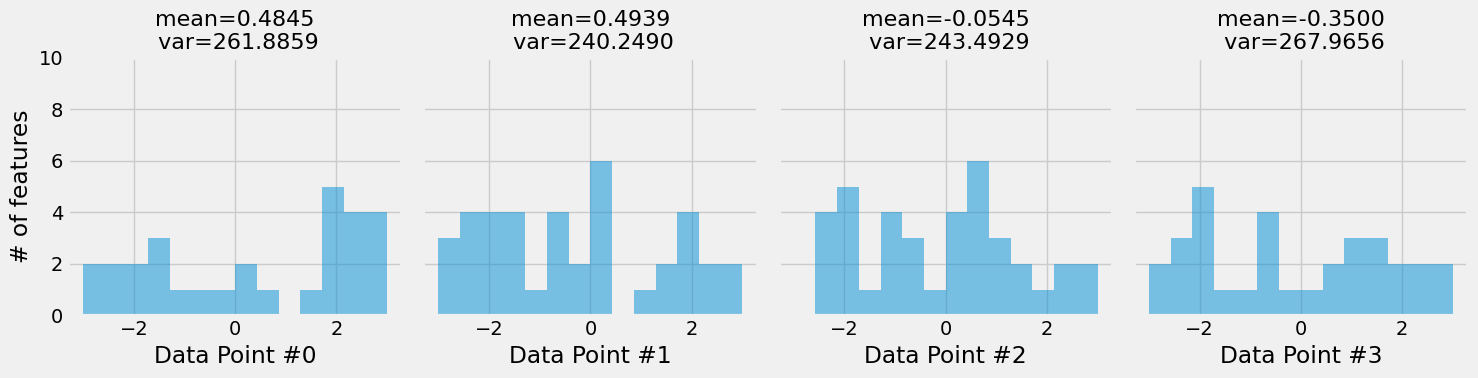

In [22]:
fig = hist_encoding(dummy_enc)

In [23]:
layer_normalizer = nn.LayerNorm(256)
dummy_normed = layer_normalizer(dummy_enc)
dummy_normed

tensor([[[-0.9210,  0.5911, -0.5127,  ..., -0.9868, -1.1467, -0.2744]],

        [[ 0.1399, -0.2607, -1.5574,  ..., -0.0925, -1.2214, -2.4460]],

        [[-1.5755, -0.1191, -1.0491,  ..., -1.1097, -1.6662, -0.8982]],

        [[ 0.8643,  1.3324,  0.6575,  ..., -0.1761, -1.0183,  0.2611]]],
       grad_fn=<NativeLayerNormBackward0>)

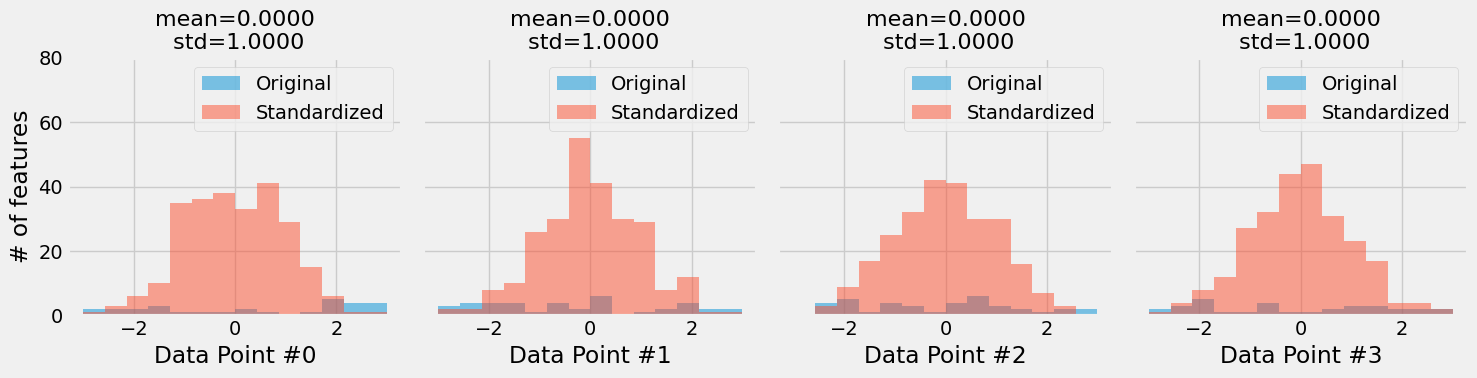

In [24]:
fig = hist_layer_normed(dummy_enc, dummy_normed)

On the batch normalization, the features are normalized in each batch, and this can impact the running statistics of the batch (each batch will have different values in terms of mean and std).

This doesn't happen with layerNorm, all the points with zero mean and unit standard deviation regardeless the choice of the mini-batches.

### Our Seq2Seq Problem

In [25]:
pe = PositionalEncoding(max_len=2, d_model=2)

source_seq = torch.tensor([[[ 1.0349,  0.9661], [ 0.8055, -0.9169]]])
source_seq_enc = pe(source_seq)
source_seq_enc

tensor([[[ 1.4636,  2.3663],
         [ 1.9806, -0.7564]]])

In [26]:
norm = nn.LayerNorm(2)
norm(source_seq_enc)

tensor([[[-1.0000,  1.0000],
         [ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)

### Projections or Embeddings

Projections or embeddings are used interchangeably but let's do the following:
- Projections for numerical values
- Embeddings for categorical ones (e.g. words)

Essentially, we need more dimensions or a representation in a higher dimensional feature space and we can do it with a simple linear layer



In [27]:
torch.manual_seed(11)
proj_dim = 6
linear_proj = nn.Linear(2, proj_dim)
pe = PositionalEncoding(2, proj_dim)

source_seq_proj = linear_proj(source_seq)
source_seq_proj_enc = pe(source_seq_proj)
source_seq_proj_enc

tensor([[[-2.0934,  1.5040,  1.8742,  0.0628,  0.3034,  2.0190],
         [-0.8853,  2.8213,  0.5911,  2.4193, -2.5230,  0.3599]]],
       grad_fn=<AddBackward0>)

In [28]:
norm = nn.LayerNorm(proj_dim)
norm(source_seq_proj_enc)

tensor([[[-1.9061,  0.6287,  0.8896, -0.3868, -0.2172,  0.9917],
         [-0.7362,  1.2864,  0.0694,  1.0670, -1.6299, -0.0568]]],
       grad_fn=<NativeLayerNormBackward0>)

## The Transformer

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/full_transformer.png?raw=1)

- A projection/embedding layer will map our original features to the dimensionality of both encoder and decoder (```d_model```)

- A final linear layer maps the decoder's output back to the original feature space.

In [32]:
'''
Parent class with small changes on encode and decode methods to take into account
the above details.
'''


class EncoderDecoderTransf(EncoderDecoderSelfAttn):
    def __init__(self, encoder, decoder, input_len, target_len, n_features):
        super(EncoderDecoderTransf, self).__init__(encoder, decoder, input_len, target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, encoder.d_model)
        self.linear = nn.Linear(encoder.d_model, n_features)

    def encode(self, source_seq, source_mask=None):
        # Projection
        source_proj = self.proj(source_seq)
        encoder_states = self.encoder(source_proj, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Projection
        target_proj = self.proj(shifted_target_seq)
        outputs = self.decoder(target_proj,
                               source_mask=source_mask,
                               target_mask=target_mask)
        # Linear
        outputs = self.linear(outputs)
        return outputs

This is the parent class

In [36]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)

    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequence_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask

    def encode(self, source_seq, source_mask):
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        outputs = self.decoder(shifted_target_seq,
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs

    def predict(self, source_seq, source_mask):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs

    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X).bool()
        source_seq = X[:, :self.input_len, :]

        self.encode(source_seq, source_mask)
        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)

        return outputs

### Data Preparation

In [37]:
# Generating training data
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
# Generating test data
test_points, test_directions = generate_sequences(seed=17)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
# Datasets and data loaders
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

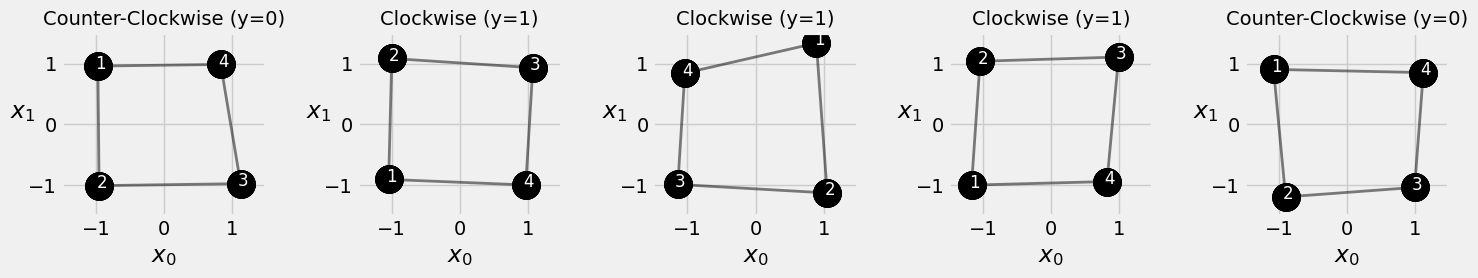

In [38]:
fig = plot_data(points, directions, n_rows=1)

### Model Configuration & Training

In [39]:
torch.manual_seed(42)
# Layers
enclayer = EncoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
declayer = DecoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
# Encoder and Decoder
enctransf = EncoderTransf(enclayer, n_layers=2)
dectransf = DecoderTransf(declayer, n_layers=2)
# Transformer
model_transf = EncoderDecoderTransf(enctransf, dectransf, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transf.parameters(), lr=0.01)

In [40]:
for p in model_transf.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [41]:
sbs_seq_transf = StepByStep(model_transf, loss, optimizer)
sbs_seq_transf.set_loaders(train_loader, test_loader)
sbs_seq_transf.train(50)

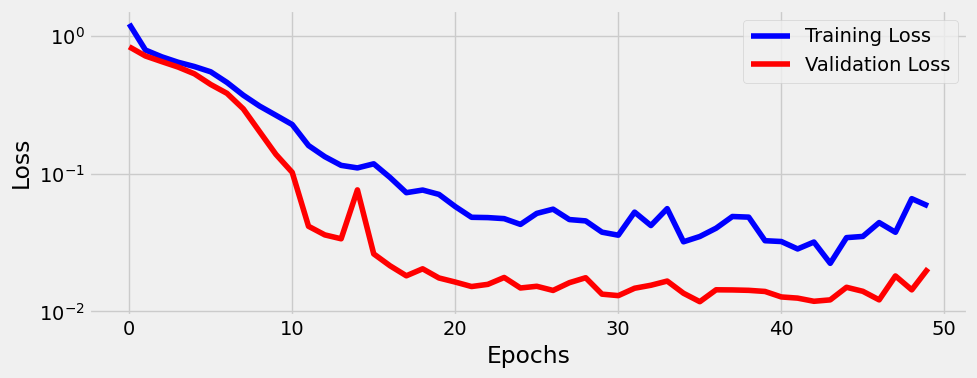

In [ ]:
fig = sbs_seq_transf.plot_losses()

In [42]:
torch.manual_seed(11)
x, y = next(iter(train_loader))
device = sbs_seq_transf.device
# Training
model_transf.train()
loss(model_transf(x.to(device)), y.to(device))

tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)

In [43]:
# Validation
model_transf.eval()
loss(model_transf(x.to(device)), y.to(device))

tensor(0.0126, device='cuda:0')

### Visualizing Predictions

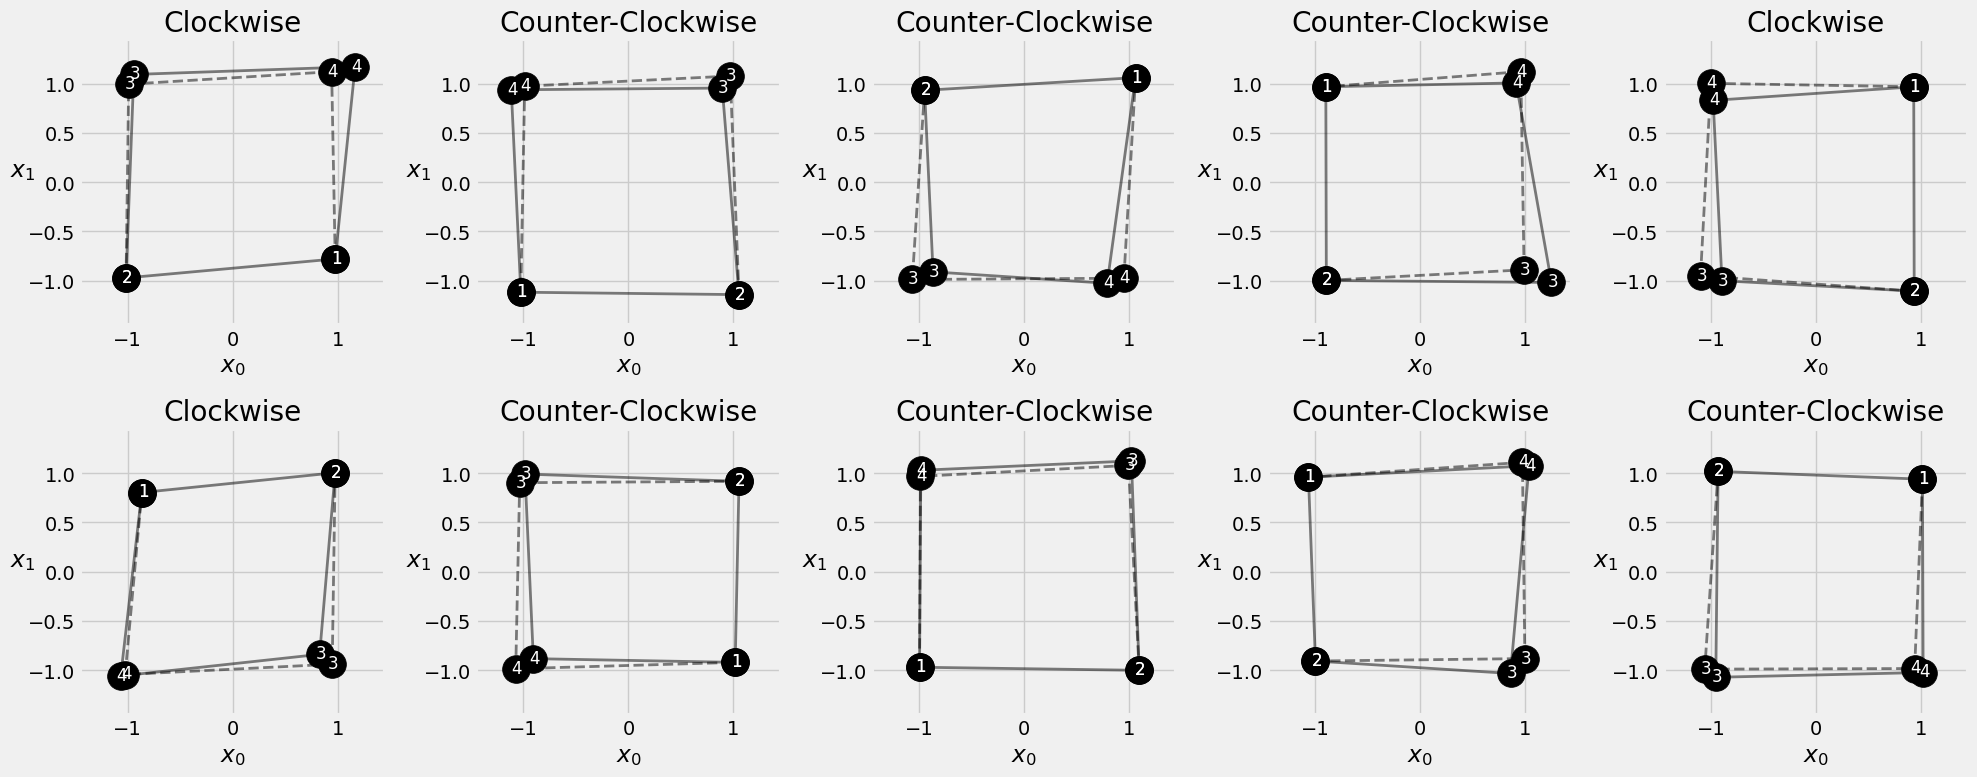

In [44]:
fig = sequence_pred(sbs_seq_transf, full_test, test_directions)

## The PyTorch Transformer

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/sublayer.png?raw=1)

Some differences to highlight:

PyTorch implements norm-last sub-layer wrappers, it normalizes the output of each sub-layer.

It doesn't implement Positional Encoding, the final layer of the projection layers, so we need to implement them.

```classtorch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1, activation=<function relu>, custom_encoder=None, custom_decoder=None, layer_norm_eps=1e-05, batch_first=False, norm_first=False, bias=True, device=None, dtype=None)```

- ```d_model```: the number of projected features, the dimensionality of the model. This number will be split among the attention heads, so it must be a multiple of the number of heads
- nhead: is the number of attention heads in each attention mechanism.
- num_encoder_layers: number of layers for the encoder
- num_decoder_layers: number of layers for the decoder
- dim_feedforward: the number of units in the hidden layer of the FFN

In [45]:
def encode_decode(self, source, target, source_mask=None, target_mask=None):
    # Projections
    src = self.preprocess(source)
    tgt = self.preprocess(target)

    out = self.transf(src, tgt,
                      src_key_padding_mask=source_mask,
                      tgt_mask=target_mask)

    # Linear
    out = self.linear(out) # N, L, F
    return out

In [47]:
class TransformerModel(nn.Module):
    def __init__(self, transformer, input_len, target_len, n_features):
        super().__init__()
        self.transf = transformer
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.transf.generate_square_subsequent_mask(self.target_len)
        self.n_features = n_features
        self.proj = nn.Linear(n_features, self.transf.d_model)
        self.linear = nn.Linear(self.transf.d_model, n_features)

        max_len = max(self.input_len, self.target_len)
        self.pe = PositionalEncoding(max_len, self.transf.d_model)
        self.norm = nn.LayerNorm(self.transf.d_model)

    def preprocess(self, seq):
        seq_proj = self.proj(seq)
        seq_enc = self.pe(seq_proj)
        return self.norm(seq_enc)

    def encode_decode(self, source, target, source_mask=None, target_mask=None):
        # Projections
        src = self.preprocess(source)
        tgt = self.preprocess(target)

        out = self.transf(src, tgt,
                          src_key_padding_mask=source_mask,
                          tgt_mask=target_mask)

        # Linear
        out = self.linear(out) # N, L, F
        return out

    def predict(self, source_seq, source_mask=None):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.encode_decode(source_seq, inputs,
                                     source_mask=source_mask,
                                     target_mask=self.trg_masks[:i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = out[:, 1:, :]
        return outputs

    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X)
        source_seq = X[:, :self.input_len, :]

        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.encode_decode(source_seq, shifted_target_seq,
                                         source_mask=source_mask,
                                         target_mask=self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)

        return outputs

### Model Configuration & Training

In [48]:
torch.manual_seed(42)
transformer = nn.Transformer(d_model=6, nhead=3,
                             num_encoder_layers=1, num_decoder_layers=1,
                             dim_feedforward=20, dropout=0.1, batch_first=True)
model_transformer = TransformerModel(transformer, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [49]:
for p in model_transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [50]:
sbs_seq_transformer = StepByStep(model_transformer, loss, optimizer)
sbs_seq_transformer.set_loaders(train_loader, test_loader)
sbs_seq_transformer.train(50)

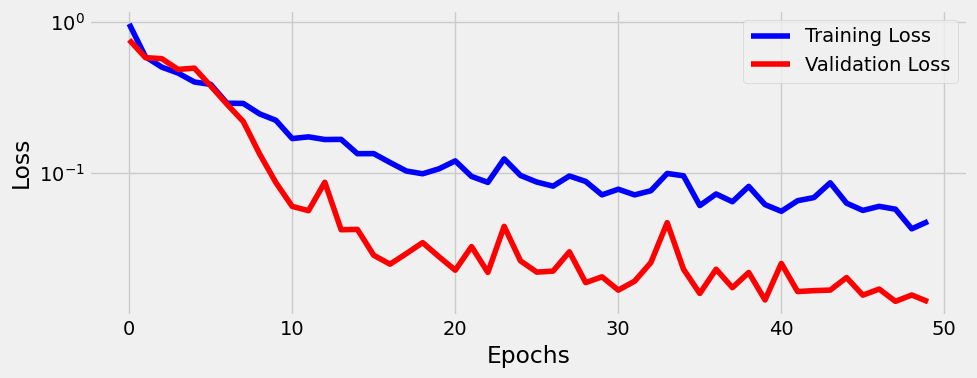

In [51]:
fig = sbs_seq_transformer.plot_losses()

### Visualizing Predictions

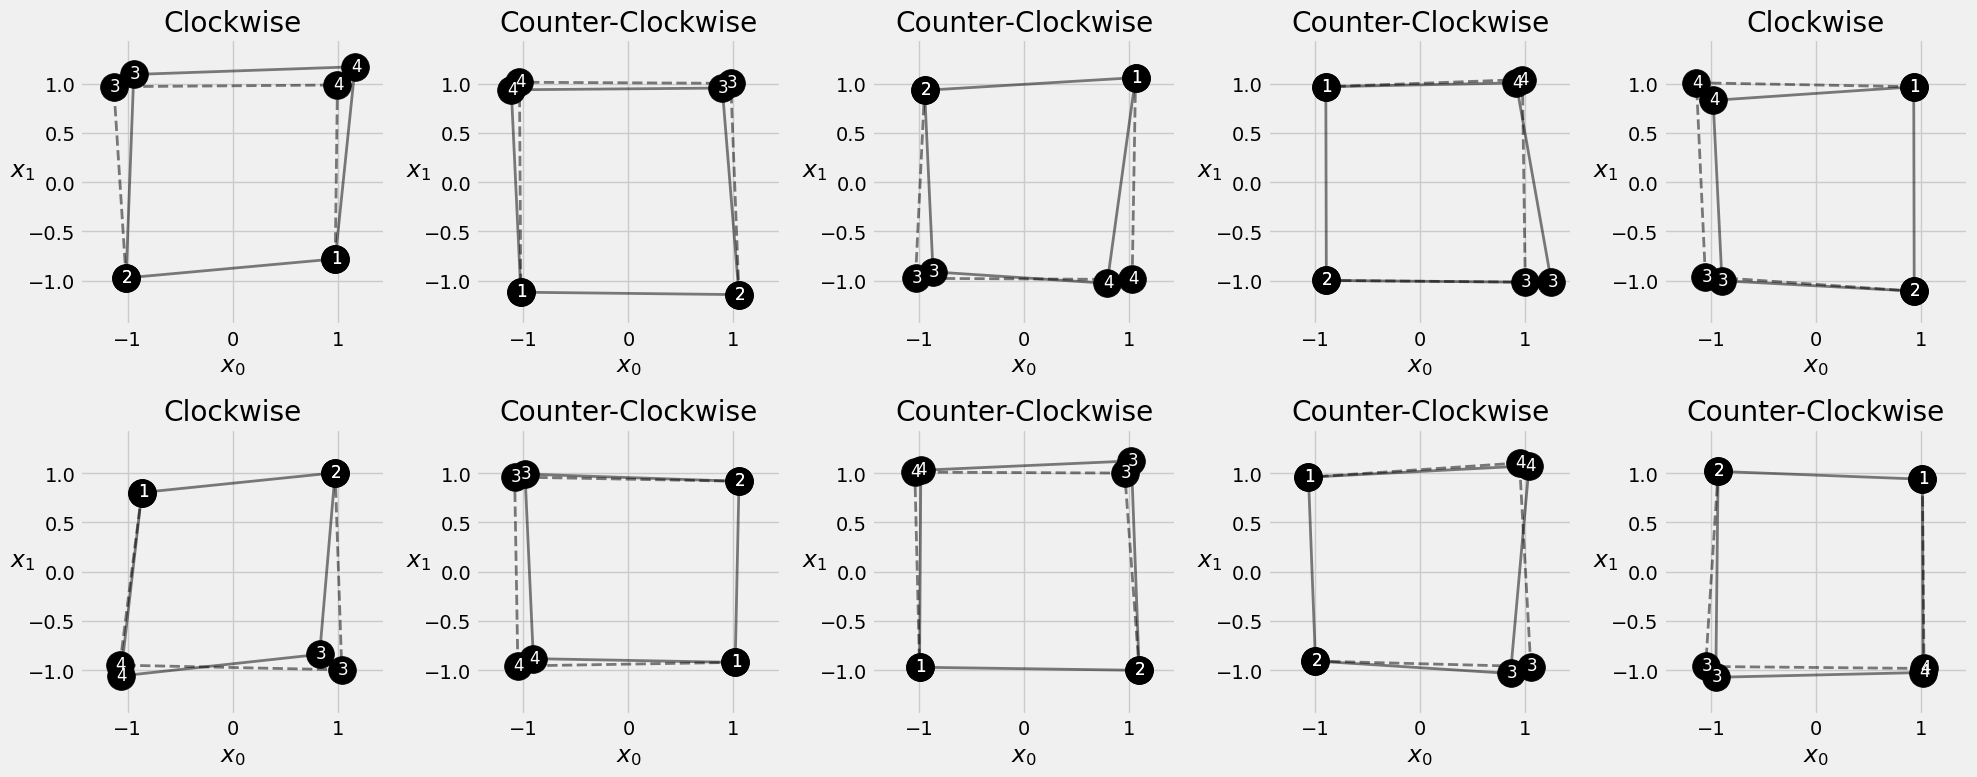

In [52]:
fig = sequence_pred(sbs_seq_transformer, full_test, test_directions)

A simple exercise, just to see how you can handle data, Dataset, DataLoader, Transformer, etc.

In [61]:
import numpy as np
import random

# Function to generate synthetic GPS trajectories with timestamps in the Florence area
def generate_gps_trajectories_with_timestamps(num_trajectories=10, sequence_length=5, predict_length=5, start_time="2024-01-01 08:00:00", time_interval=15):
    from datetime import datetime, timedelta

    # Coordinates for the center of Florence, Italy
    florence_center_lat = 43.7696
    florence_center_lon = 11.2558
    max_offset = 0.01  # Small offset for realistic variation around the center point

    sequences = []
    next_points = []

    for _ in range(num_trajectories):
        # Initialize starting point and time near Florence center
        trajectory = []
        current_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")

        # Generate initial trajectory points with timestamps
        for _ in range(sequence_length):
            point = [
                florence_center_lat + random.uniform(-max_offset, max_offset),   # Latitude
                florence_center_lon + random.uniform(-max_offset, max_offset),   # Longitude
                current_time.timestamp()                                         # Timestamp in seconds
            ]
            trajectory.append(point)
            current_time += timedelta(minutes=time_interval)  # Increment time by time_interval

        # Generate future points (predictions) with timestamps
        future_points = []
        for _ in range(predict_length):
            last_point = trajectory[-1] if not future_points else future_points[-1]
            new_point = [
                last_point[0] + random.uniform(-0.001, 0.001),  # Small latitude step
                last_point[1] + random.uniform(-0.001, 0.001),  # Small longitude step
                last_point[2] + (time_interval * 60)            # Increment time by time_interval in seconds
            ]
            future_points.append(new_point)

        # Append trajectory (input) and future points (target) to lists
        sequences.append(trajectory)
        next_points.append(future_points)

    # Convert to numpy arrays for use in models
    sequences_np = np.array(sequences)
    next_points_np = np.array(next_points)

    return sequences_np, next_points_np

# Generate sample Florence GPS trajectories with timestamps
train_gps_sequences_with_time_np, train_gps_next_points_with_time_np = generate_gps_trajectories_with_timestamps(100)
valid_gps_sequences_with_time_np, valid_gps_next_points_with_time_np = generate_gps_trajectories_with_timestamps(20)
test_gps_sequences_with_time_np, test_gps_next_points_with_time_np = generate_gps_trajectories_with_timestamps(20)


In [64]:
train_gps_sequences_with_time_np[0][:,0]

array([[43.77688101, 11.25881939],
       [43.77334321, 11.24905313],
       [43.76107419, 11.26271525],
       [43.76549817, 11.25217434],
       [43.77863324, 11.24728401]])

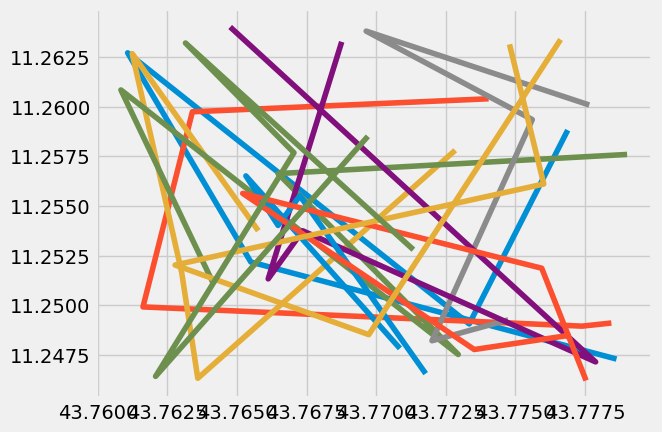

In [69]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(train_gps_sequences_with_time_np[i][:,0],train_gps_sequences_with_time_np[i][:,1])


Use/adapt the transformer architecture and data structures (if needed) to train a transformer, estimate of the error and possibly see the attention scores to see for a given input sequence which are the points where the transformer pays attention more.

## Vision Transformer

### Data Generation & Preparation

In [ ]:
images, labels = generate_dataset(img_size=12, n_images=1000, binary=False, seed=17)

In [ ]:
img = torch.as_tensor(images[2]).unsqueeze(0).float()/255.

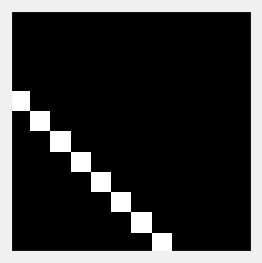

In [ ]:
fig = plot_images(img, title=False)

In [ ]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# We're not doing any data augmentation now
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Patches

#### Rearranging

In [ ]:
# Adapted from https://discuss.pytorch.org/t/tf-extract-image-patches-in-pytorch/43837
def extract_image_patches(x, kernel_size, stride=1):
    # Extract patches
    patches = x.unfold(2, kernel_size, stride)
    patches = patches.unfold(3, kernel_size, stride)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()

    return patches.view(x.shape[0], patches.shape[1], patches.shape[2], -1)

In [ ]:
kernel_size = 4
patches = extract_image_patches(img, kernel_size, stride=kernel_size)
patches.shape

torch.Size([1, 3, 3, 16])

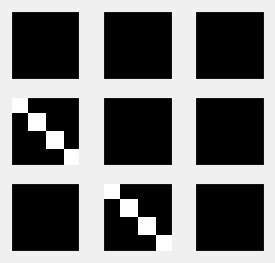

In [ ]:
fig = plot_patches(patches, kernel_size=kernel_size)

In [ ]:
seq_patches = patches.view(-1, patches.size(-1))

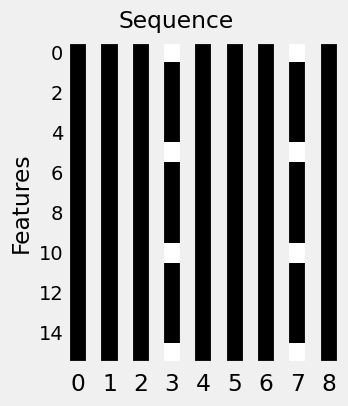

In [ ]:
fig = plot_seq_patches(seq_patches)

In [ ]:
# Adapted from https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_pytorch.py
# !pip install einops
# from einops import rearrange
# patches = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
#                     p1 = kernel_size, p2 = kernel_size)
# patches.shape

#### Embeddings

In [ ]:
# Adapted from https://amaarora.github.io/2021/01/18/ViT.html
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, dilation=1):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [ ]:
torch.manual_seed(13)
patch_embed = PatchEmbed(img.size(-1), kernel_size, 1, kernel_size**2)
embedded = patch_embed(img)
embedded.shape

torch.Size([1, 9, 16])

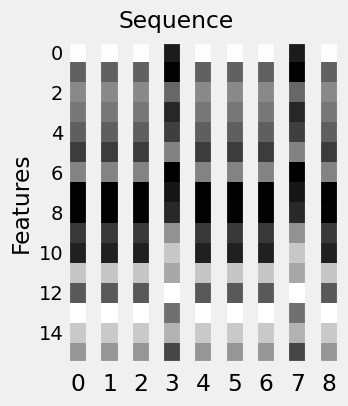

In [ ]:
fig = plot_seq_patches(embedded[0])

### Special Classifier Token

In [ ]:
imgs = torch.as_tensor(images[2:4]).float()/255.

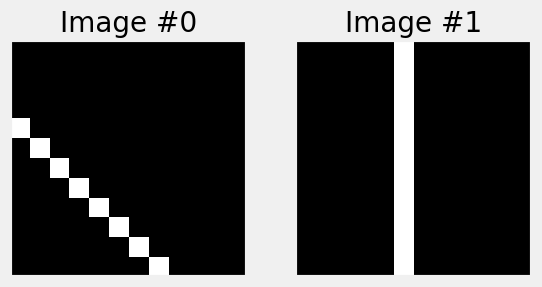

In [ ]:
fig = plot_images(imgs)

In [ ]:
embeddeds = patch_embed(imgs)

/home/dvgodoy/projects/PyTorchStepByStep/plots/chapter10.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i+1].set_yticklabels([label], rotation=0)


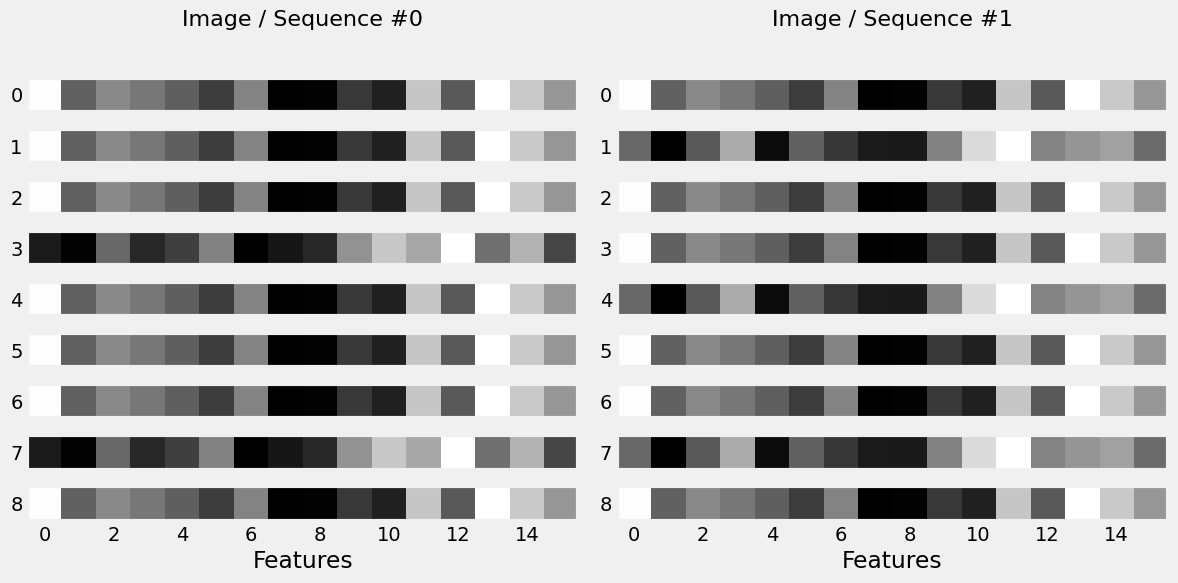

In [ ]:
fig = plot_seq_patches_transp(embeddeds, add_cls=False, title='Image / Sequence')

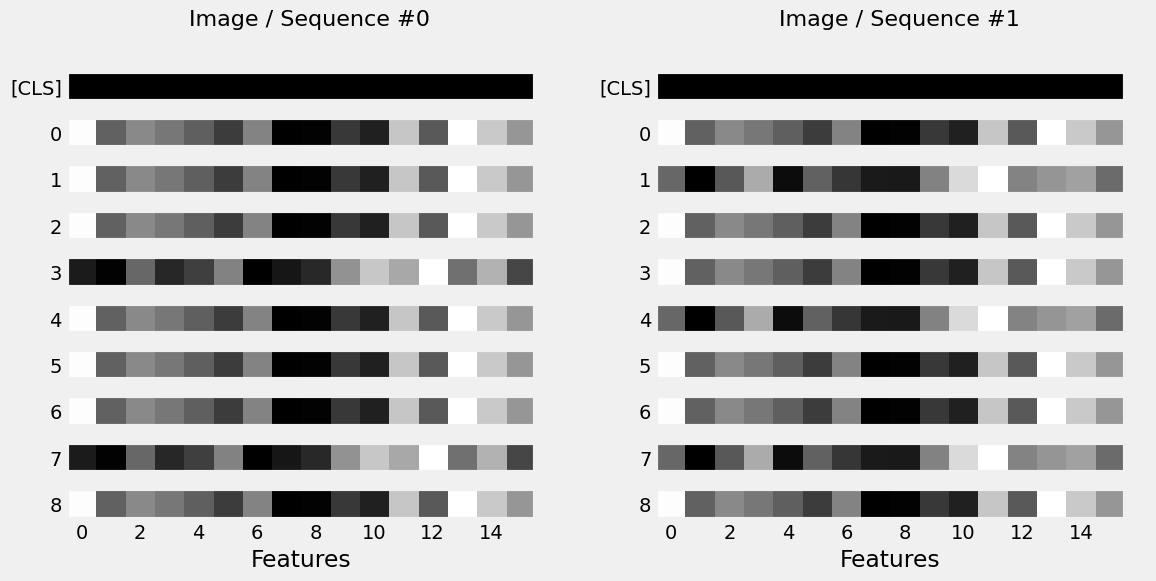

In [ ]:
fig = plot_seq_patches_transp(embeddeds, add_cls=True, title='Image / Sequence')

In [ ]:
cls_token = nn.Parameter(torch.zeros(1, 1, 16))
cls_token

Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       requires_grad=True)

In [ ]:
images, labels = next(iter(train_loader))
images.shape # N, C, H, W

torch.Size([16, 1, 12, 12])

In [ ]:
embed = patch_embed(images)
embed.shape # N, L, D

torch.Size([16, 9, 16])

In [ ]:
cls_tokens = cls_token.expand(embed.size(0), -1, -1)
embed_cls = torch.cat((cls_tokens, embed), dim=1)
embed_cls.shape # N, L+1, D

torch.Size([16, 10, 16])

### The Model

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/vit_model.png?raw=1)

In [ ]:
class ViT(nn.Module):
    def __init__(self, encoder, img_size, in_channels, patch_size, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(encoder.d_model, n_outputs)

        self.embed = PatchEmbed(img_size, patch_size, in_channels, encoder.d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, encoder.d_model))

    def preprocess(self, X):
        # Patch embeddings
        # N, C, H, W -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source):
        # Encoder generates "hidden states"
        states = self.encoder(source)
        # Gets state from first token: CLS
        cls_state = states[:, 0]  # N, 1, D
        return cls_state

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src)
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

### Model Configuration & Training

In [ ]:
torch.manual_seed(17)
layer = EncoderLayer(n_heads=2, d_model=16, ff_units=20)
encoder = EncoderTransf(layer, n_layers=1)
model_vit = ViT(encoder, img_size=12, in_channels=1, patch_size=4, n_outputs=3)
multi_loss_fn = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(model_vit.parameters(), lr=1e-3)

In [ ]:
sbs_vit = StepByStep(model_vit, multi_loss_fn, optimizer_vit)
sbs_vit.set_loaders(train_loader, val_loader)
sbs_vit.train(20)

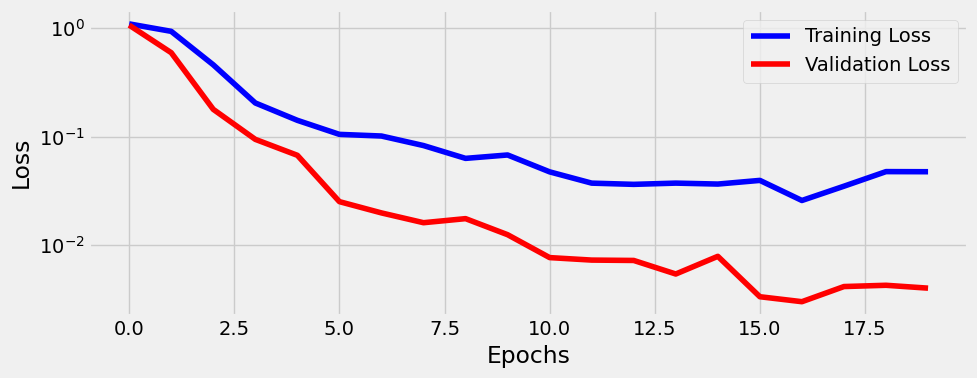

In [ ]:
fig = sbs_vit.plot_losses()

In [ ]:
model_vit.cls_token

Parameter containing:
tensor([[[ 0.0590, -0.0471, -0.0053, -0.0251,  0.0360, -0.0394,  0.0585,
          -0.0263,  0.0189, -0.0419,  0.0033, -0.0117,  0.0961, -0.0380,
           0.0486, -0.0424]]], requires_grad=True)

In [ ]:
StepByStep.loader_apply(sbs_vit.val_loader, sbs_vit.correct)

tensor([[76, 76],
        [65, 65],
        [59, 59]])

## Putting It All Together

### Data Preparation

In [ ]:
# Training set
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
train_data = TensorDataset(full_train, target_train)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)

# Validation/Test Set
test_points, test_directions = generate_sequences(seed=17)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
test_data = TensorDataset(source_test, target_test)
test_loader = DataLoader(test_data, batch_size=16)

### Model Assembly

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/full_transformer_and_class.png?raw=1)

#### 1. Encoder-Decoder

In [ ]:
class EncoderDecoderTransf(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, n_features):
        super(EncoderDecoderTransf, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)

        self.n_features = n_features
        self.proj = nn.Linear(n_features, encoder.d_model)
        self.linear = nn.Linear(encoder.d_model, n_features)

    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask

    def encode(self, source_seq, source_mask=None):
        # Projection
        source_proj = self.proj(source_seq)
        encoder_states = self.encoder(source_proj, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Projection
        target_proj = self.proj(shifted_target_seq)
        outputs = self.decoder(target_proj,
                               source_mask=source_mask,
                               target_mask=target_mask)
        # Linear
        outputs = self.linear(outputs)
        return outputs

    def predict(self, source_seq, source_mask):
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs

    def forward(self, X, source_mask=None):
        self.trg_masks = self.trg_masks.type_as(X).bool()
        source_seq = X[:, :self.input_len, :]

        self.encode(source_seq, source_mask)
        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            outputs = self.predict(source_seq, source_mask)

        return outputs

#### 2. Encoder

In [ ]:
class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer)
                                     for _ in range(n_layers)])

    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

#### 3. Decoder

In [ ]:
class DecoderTransf(nn.Module):
    def __init__(self, decoder_layer, n_layers=1, max_len=100):
        super(DecoderTransf, self).__init__()
        self.d_model = decoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer)
                                     for _ in range(n_layers)])

    def init_keys(self, states):
        for layer in self.layers:
            layer.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, source_mask, target_mask)
        # Norm
        return self.norm(x)

#### 4. Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        slope = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * slope) # even dimensions
        pe[:, 1::2] = torch.cos(position * slope) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

#### 5. Encoder "Layer"

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                    dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        self.sublayers = nn.ModuleList([SubLayerWrapper(d_model, dropout) for _ in range(2)])

    def forward(self, query, mask=None):
        # SubLayer 0 - Self-Attention
        att = self.sublayers[0](query,
                                sublayer=self.self_attn_heads,
                                is_self_attn=True,
                                mask=mask)
        # SubLayer 1 - FFN
        out = self.sublayers[1](att, sublayer=self.ffn)
        return out

#### 6. Decoder "Layer"

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                    dropout=dropout)
        self.cross_attn_heads = MultiHeadedAttention(n_heads, d_model,
                                                     dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )
        self.sublayers = nn.ModuleList([SubLayerWrapper(d_model, dropout) for _ in range(3)])

    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        # SubLayer 0 - Masked Self-Attention
        att1 = self.sublayers[0](query,
                                 sublayer=self.self_attn_heads,
                                 is_self_attn=True,
                                 mask=target_mask)
        # SubLayer 1 - Cross-Attention
        att2 = self.sublayers[1](att1,
                                 sublayer=self.cross_attn_heads,
                                 mask=source_mask)
        # SubLayer 2 - FFN
        out = self.sublayers[2](att2, sublayer=self.ffn)
        return out

#### 7. "SubLayer" Wrapper

In [ ]:
class SubLayerWrapper(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, sublayer, is_self_attn=False, **kwargs):
        norm_x = self.norm(x)
        if is_self_attn:
            sublayer.init_keys(norm_x)
        out = x + self.drop(sublayer(norm_x, **kwargs))
        return out

In [ ]:
# Before
def forward(self, query, mask=None):
    # query and mask go in
    norm_query = self.norm1(query)
    self.self_attn_heads.init_keys(norm_query)
    # the sublayer is the self-attention
    states = self.self_attn_heads(norm_query, mask)
    att = query + self.drop1(states)
    # att comes out
    ...

# After
def forward(self, query, mask=None):
    # query and mask go in
    # the sublayer is the self-attention
    # norm, drop, and residual are inside the wrapper
    att = self.sublayers[0](query,
                            sublayer=self.self_attn_heads,
                            is_self_attn=True,
                            mask=mask)
    # att comes out
    ...

#### 8. Multi-Headed Attention

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))

    def score_function(self, query):
        # scaled dot product
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query,
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores

    def attn(self, query, mask=None):
        # Query is batch-first: N, L, D
        # Score function will generate scores for each head
        scores = self.score_function(query) # N, n_heads, L, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()

        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)
        return context

    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D
        return out

    def forward(self, query, mask=None):
        if mask is not None:
            # N, 1, L, L - every head uses the same mask
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)
        # N, L, d_model
        out = self.output_function(context)
        return out

### Model Configuration & Training

In [ ]:
torch.manual_seed(42)
# Layers
enclayer = EncoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
declayer = DecoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
# Encoder and Decoder
enctransf = EncoderTransf(enclayer, n_layers=2)
dectransf = DecoderTransf(declayer, n_layers=2)
# Transformer
model_transf = EncoderDecoderTransf(enctransf, dectransf, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transf.parameters(), lr=0.01)

In [ ]:
for p in model_transf.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
sbs_seq_transf = StepByStep(model_transf, loss, optimizer)
sbs_seq_transf.set_loaders(train_loader, test_loader)
sbs_seq_transf.train(50)

In [ ]:
sbs_seq_transf.losses[-1], sbs_seq_transf.val_losses[-1]

(0.05839654209557921, 0.020480516366660595)